# Georeferencing Script 

## Importing the Library

In [1]:
import laspy
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Read the LAS File

In [2]:
#Read Las File Function

def read_lasfile(input_file):
    # Path to your LAS file
    las_file_path = input_file

    # Read LAS file
    with laspy.open(las_file_path) as las:
        points = las.read().points

    # Extract x, y, z coordinates
    x = points['X'] * las.header.scale[0] + las.header.offset[0]
    y = points['Y'] * las.header.scale[1] + las.header.offset[1]
    z = points['Z'] * las.header.scale[2] + las.header.offset[2]

    #Extract the intensity value
    #intensity = points['intensity']


    # Combine into a single array
    point_cloud_array = np.vstack((x, y, z)).T

    # Create Open3D PointCloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(point_cloud_array)

    #Map Intensity
    #colors = np.vstack((intensity, intensity, intensity)).T
    #point_cloud.colors = o3d.utility.Vector3dVector(colors)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([point_cloud])


## Convert the Unit

In [3]:
import laspy
import numpy as np

def convert_las_units_to_meters(input_file, output_file):
    """
    Convert LAS file coordinates from millimeters to meters and save as a new file.

    Parameters:
    - input_file (str): Path to the input LAS file with millimeter units.
    - output_file (str): Path to the output LAS file with meter units.
    """
    # Load the LAS file
    las = laspy.read(input_file)

    # Convert coordinates from millimeters to meters
    points_in_meters = np.vstack((las.x, las.y, las.z)).T / 1000  # Convert points to meters
    offsets_in_meters = las.header.offsets / 1000  # Convert offsets to meters
    scales = las.header.scales  # Keep scales the same

    # Create a new LAS header and set the updated offsets and scales
    header = laspy.LasHeader(point_format=las.header.point_format, version=las.header.version)
    header.offsets = offsets_in_meters
    header.scales = scales

    # Create a new LAS file with converted points
    converted_las = laspy.LasData(header)
    converted_las.x = points_in_meters[:, 0]
    converted_las.y = points_in_meters[:, 1]
    converted_las.z = points_in_meters[:, 2]
    converted_las.intensity = las.intensity  # Copy over intensity

    # Save the converted points to a new LAS file
    converted_las.write(output_file)
    print(f"Converted LAS file saved to {output_file}")


## Filter and Save the Point Cloud  to New Files

In [4]:
def filter_points_by_intensity(input_file, output_file, lowest_intensity, highest_intensity):
    # Load LAS file
    las = laspy.read(input_file)

    # Extract points and intensities
    points = np.vstack((las.x, las.y, las.z)).T
    intensities = las.intensity

    # Filter points by intensity within the specified tolerance
    mask = (intensities >= lowest_intensity) & (intensities <= highest_intensity)
    filtered_points = points[mask]
    filtered_intensities = intensities[mask]

    # Create a new LAS header
    header = laspy.LasHeader(point_format=las.header.point_format, version=las.header.version)
    header.offsets = las.header.offsets
    header.scales = las.header.scales

    # Create a new LAS file with filtered points
    filtered_las = laspy.LasData(header)
    filtered_las.x = filtered_points[:, 0]
    filtered_las.y = filtered_points[:, 1]
    filtered_las.z = filtered_points[:, 2]
    filtered_las.intensity = filtered_intensities

    # Save the filtered points to a new LAS file
    filtered_las.write(output_file)

In [5]:
# Set parameters
input_file = r"C:\Users\Darmawan\OneDrive - Geobotica Pty Ltd\Project\3\Data\30km\converted_scans_2024-09-10-18-11-20.las"
output_file = r"C:\Users\Darmawan\OneDrive - Geobotica Pty Ltd\Project\3\Data\30km\trial_converted_scans_2024-09-10-18-11-20.las"
lowest = 200  # Example intensity value
highest = 255  # Adjust tolerance as needed

# Filter points by intensity and save to output LAS file
filter_points_by_intensity(input_file, output_file, lowest, highest)

## Clustering the Points with Certain Intensity Value using DBSCAN

In [6]:
def extract_xy (output_file, eps, sample):
    # Path to your LAS file
    las_file_path = output_file

    # Read LAS file
    with laspy.open(las_file_path) as las:
        points = las.read().points

    # Extract x, y, z coordinates
    x = points['X'] * las.header.scale[0] + las.header.offset[0]
    y = points['Y'] * las.header.scale[1] + las.header.offset[1]
    z = points['Z'] * las.header.scale[2] + las.header.offset[2]
    intensity = points ['intensity']
    # Combine x and y into a 2D array
    xy_array = np.vstack((x, y,z)).T
    
    # DBSCAN Clustering
    eps = eps  # Maximum distance between two points to be in the same neighborhood
    min_samples = sample  # Minimum number of points to form a dense cluster
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(xy_array)

    #combining the xy and labels
    xy_with_labels = np.hstack((xy_array, labels[:, np.newaxis]))

    # Visualize the clusters
    plt.figure(figsize=(10, 8))
    unique_labels = set(labels)

    for label in unique_labels:
        if label == -1:
            # Noise points
            color = 'k'
            marker = 'x'
            label_name = 'Noise'
        else:
            # Cluster points
            color = plt.cm.Spectral(float(label) / len(unique_labels))
            marker = 'o'
            label_name = f'Cluster {label}'

        cluster_points = xy_array[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=label_name, marker=marker)
    
    # Add labels near the points
        for point in cluster_points:
            plt.text(point[0], point[1], str(label), fontsize=18, color=color, alpha=1)

    plt.title("DBSCAN Clustering of XY Points")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.show()
    
    return labels, xy_with_labels

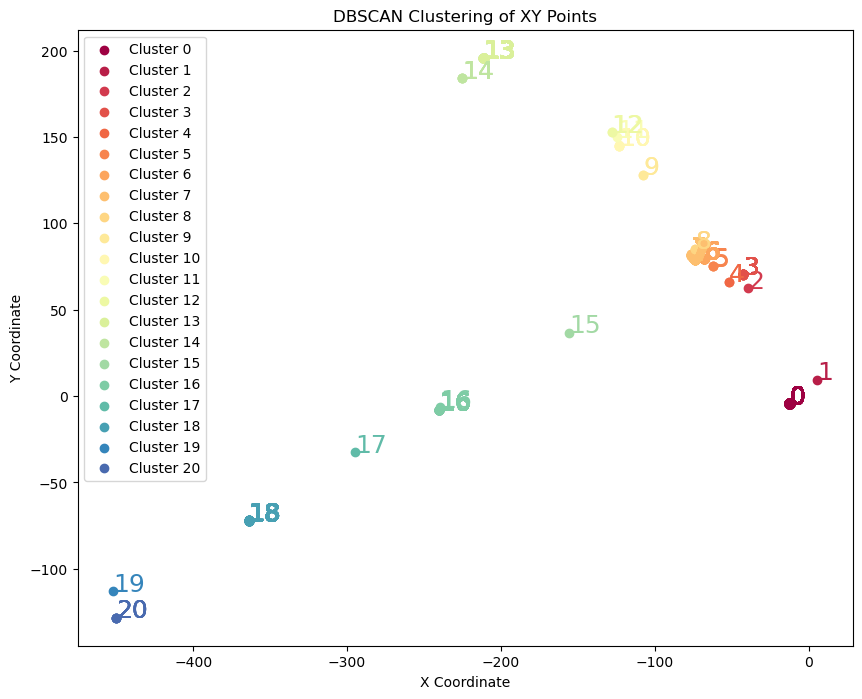

In [7]:
labels, xy_with_labels = extract_xy(output_file,3,1)

## Calculating the Centroid for all Clusters, then Distances for all centroids

In [15]:
import numpy as np

# Assuming `xy_with_labels` contains the points and their labels
# Each row: [x, y, z, ..., label]

# Extract unique cluster labels from 0 to 352
#unique_labels = np.arange(0, 353)  # Generate range from 0 to 352

unique_labels = set(labels)

# Initialize a dictionary to store centroids
centroids = {}

# Step 1: Calculate centroids for all clusters
for label in unique_labels:
    cluster_points = xy_with_labels[xy_with_labels[:, -1] == label]
    if cluster_points.size > 0:  # Check if the cluster has points
        centroids[label] = cluster_points[:, :3].mean(axis=0)
    else:
        centroids[label] = None  # Mark empty clusters as None

# Step 2: Calculate distances between all cluster pairs
distances = {}

for i in unique_labels:
    for j in unique_labels:
        if i < j:  # To avoid duplicate calculations and self-distances
            if centroids[i] is not None and centroids[j] is not None:
                # Compute Euclidean distance
                distance = np.linalg.norm(centroids[i] - centroids[j])
                distances[(i, j)] = distance

# Output the distances
#for (cluster_a, cluster_b), distance in distances.items():
    #print(f"Distance between Cluster {cluster_a} and Cluster {cluster_b}: {distance}")


## Extract the Distances for all Actual Prisms

In [9]:
import numpy as np

# Define the known points of Daniel Decline area
cp_danieldec = {
    "M207501": [50110.995, 100230.157, 2076.059998],
    "MD22": [50234.382, 100363.905, 2102.934998],
    "S214501": [50236.321, 100589.829, 2148.884998],
    "MD04": [50475.915, 100512.543, 2186.743998]
}

# Extract labels
labels_cp = np.array(list(cp_danieldec.keys()))

# Initialize dictionary to store distances
distances_cp = {}

# Calculate distances
for i in labels_cp:
    for j in labels_cp:
        if i < j:  # To avoid duplicate calculations and self-distances
            # Convert lists to NumPy arrays for mathematical operations
            point_i = np.array(cp_danieldec[i])
            point_j = np.array(cp_danieldec[j])
            
            # Compute Euclidean distance
            distance = np.linalg.norm(point_i - point_j)
            
            # Store the distance in the dictionary
            distances_cp[(i, j)] = distance

# Output distances
for pair, distance in distances_cp.items():
    print(f"Distance between {pair}: {distance}")
    

Distance between ('M207501', 'MD22'): 183.94331979715042
Distance between ('M207501', 'S214501'): 387.7809104184914
Distance between ('M207501', 'MD04'): 474.50964927174863
Distance between ('MD22', 'S214501'): 230.55761968974173
Distance between ('MD04', 'MD22'): 295.72858098939867
Distance between ('MD04', 'S214501'): 254.5814496639486


## Find the correspondence by comparing the distances between actual prisms and their candidates

The pairing process was done by using a tolerance of 2 meter. The lower value indicates good data.

In [17]:
save_pair = []
# Access each value
for key, value in distances_cp.items():
    # Threshold to find distances around 183
    threshold = value
    tolerance = 2  # +/- range

    # Find all distances within the range [182, 184]
    distances_around_value = {
        pair: distance for pair, distance in distances.items() if abs(distance - threshold) <= tolerance
    }

    # Output the result
    for pair, distance in distances_around_value.items():
        save_pair.append(pair)
        print(f"Distance between {pair}: {distance}")


Distance between (17, 20): 182.94609988616867
Distance between (14, 20): 387.5016232985805
Distance between (2, 13): 229.9454920553271
Distance between (14, 17): 229.94207480553663
Distance between (1, 16): 254.79723821285037
Distance between (6, 17): 254.27916004013974


In [18]:
cluster_pair = set(save_pair)

# Extract unique cluster numbers
unique_clusters = set()  # Initialize an empty set
for pair in cluster_pair:
    unique_clusters.update(pair)  # Add each number from the tuple to the set

# Convert to a sorted list if needed
unique_clusters_list_filtered = sorted(unique_clusters)

In [19]:
# Filter the centroids dictionary
filtered_data_cluster_list = {key: value for key, value in centroids.items() if key in unique_clusters_list_filtered}

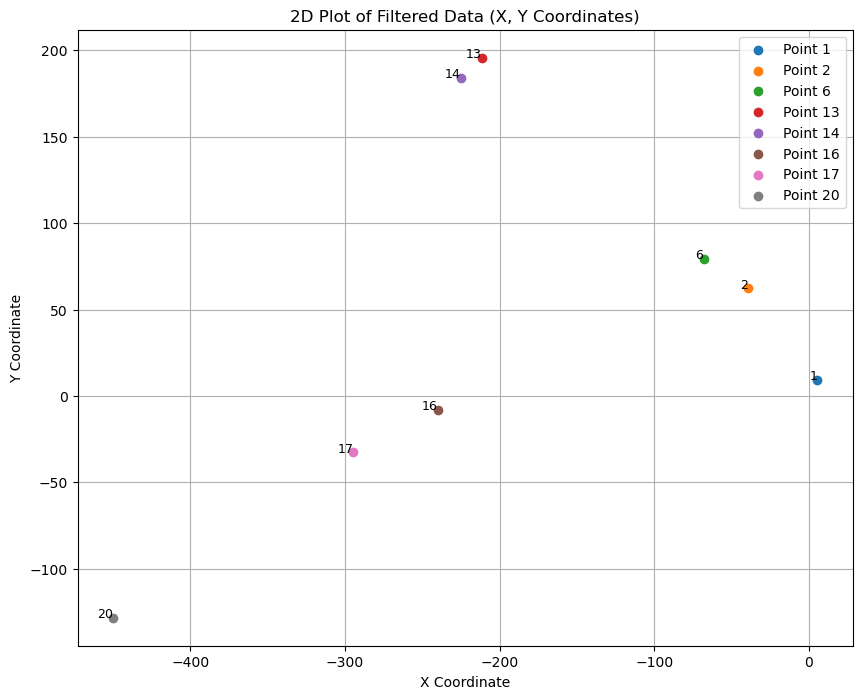

In [20]:
# Plot the dictionary in 2D (x, y coordinates) using matplotlib
plt.figure(figsize=(10, 8))

for key, value in filtered_data_cluster_list.items():
    x, y = value[0], value[1]  # Extract x and y coordinates
    plt.scatter(x, y, label=f"Point {key}")
    plt.text(x, y, f"{key}", fontsize=9, ha='right')

plt.title("2D Plot of Filtered Data (X, Y Coordinates)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)
plt.show()


## Second filter with higher Tolerance 

The higher tolerance was used for excluding the 'fake' prism with 1 metre of tolerance.

In [21]:
import numpy as np
from itertools import combinations

# Convert to arrays
detected_prisms = np.array(list(filtered_data_cluster_list.values()))
actual_prisms = np.array(list(cp_danieldec.values()))

# Function to compute pairwise distances between nodes
def compute_pairwise_distances(points):
    distances = {}
    for i, j in combinations(range(len(points)), 2):
        dist = np.linalg.norm(points[i] - points[j])
        distances[(i, j)] = dist
    return distances

# Compute pairwise distances
detected_distances = compute_pairwise_distances(detected_prisms)
actual_distances = compute_pairwise_distances(actual_prisms)

# Graph Matching
def match_graphs(detected_distances, actual_distances, threshold=50.0):
    mapping = {}  # Map actual node to detected node
    unmatched_actual = set(range(len(actual_prisms)))  # Unmatched actual nodes
    unmatched_detected = set(range(len(detected_prisms)))  # Unmatched detected nodes

    # Match based on distance
    for (ai, aj), actual_dist in actual_distances.items():
        for (di, dj), detected_dist in detected_distances.items():
            if abs(actual_dist - detected_dist) <= threshold:
                mapping[(ai, aj)] = (di, dj)
                unmatched_actual.discard(ai)
                unmatched_actual.discard(aj)
                unmatched_detected.discard(di)
                unmatched_detected.discard(dj)

    return mapping, unmatched_actual, unmatched_detected

# Perform graph matching
threshold = 1  # Tolerance for matching edge lengths
mapping, unmatched_actual, unmatched_detected = match_graphs(detected_distances, actual_distances, threshold)

# Extract matched coordinates for nodes based on the mapping
matched_coordinates = {
    (ai, aj): (detected_prisms[di], detected_prisms[dj])
    for (ai, aj), (di, dj) in mapping.items()
}

# Print the matched coordinates
print("Matched Node Coordinates (Actual -> Detected):")
for (ai, aj), (detected1, detected2) in matched_coordinates.items():
    print(f"Actual Nodes {ai}-{aj} -> Detected Nodes: {detected1.tolist()}, {detected2.tolist()}")

# Print unmatched actual node coordinates
print("\nUnmatched Actual Node Coordinates:")
for node in unmatched_actual:
    print(f"Actual Node {node}: {actual_prisms[node].tolist()}")

# Print unmatched detected node coordinates
print("\nUnmatched Detected Node Coordinates:")
for node in unmatched_detected:
    print(f"Detected Node {node}: {detected_prisms[node].tolist()}")


Matched Node Coordinates (Actual -> Detected):
Actual Nodes 0-1 -> Detected Nodes: [-294.67, -32.46, -62.571], [-450.1924, -128.31660000000002, -52.897800000000004]
Actual Nodes 0-2 -> Detected Nodes: [-225.07925000000003, 184.1095, -96.15875], [-450.1924, -128.31660000000002, -52.897800000000004]
Actual Nodes 1-2 -> Detected Nodes: [-225.07925000000003, 184.1095, -96.15875], [-294.67, -32.46, -62.571]
Actual Nodes 2-3 -> Detected Nodes: [-68.07693939393941, 79.38412121212122, -34.209606060606056], [-294.67, -32.46, -62.571]

Unmatched Actual Node Coordinates:

Unmatched Detected Node Coordinates:


In [22]:
# Store the matched coordinates into a list
matched_list = []
for (ai, aj), (detected1, detected2) in matched_coordinates.items():
    matched_list.append({
        "actual_nodes": (ai, aj),
        "detected_coordinates": [detected1.tolist(), detected2.tolist()]
    })

# Flatten the matched coordinates into a single list of [x, y, z]
flattened_matched_list = []
for match in matched_list:
    for coord in match["detected_coordinates"]:
        flattened_matched_list.append(coord)

# Ensure uniqueness to avoid duplicates
unique_flattened_list = [list(x) for x in set(tuple(x) for x in flattened_matched_list)]

# Sort the list based on the x-coordinate (first value in each sublist)
sorted_list = sorted(unique_flattened_list, key=lambda x: x[0])

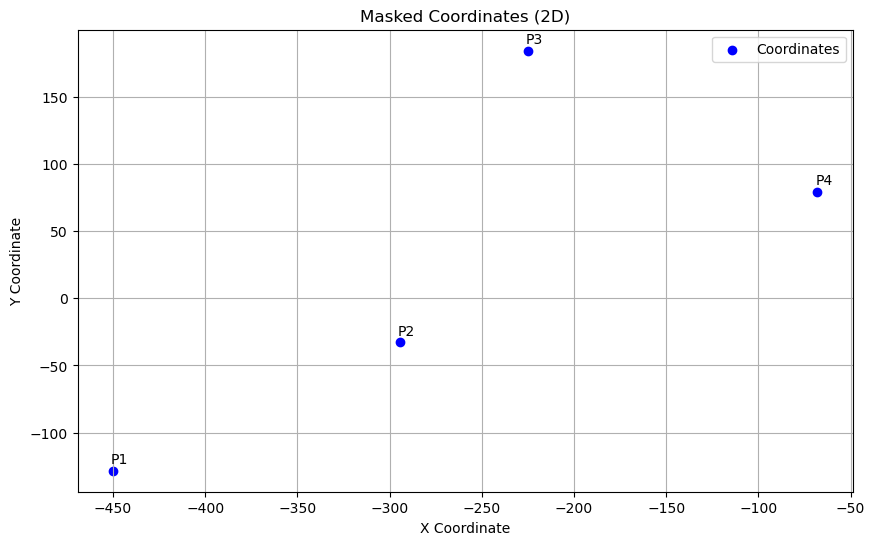

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list of coordinates into a NumPy array
coordinate_array = np.array(sorted_list)

# Extract X and Y for 2D plotting
x_coords = coordinate_array[:, 0]  # First column (X)
y_coords = coordinate_array[:, 1]  # Second column (Y)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, c='blue', label='Coordinates')
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.annotate(f'P{i+1}', (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

plt.title('Masked Coordinates (2D)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()


## Third filter was conducted by using the Angle for all Clusters

This process filters the 'fake' prism with another parameter. In this case, we used angle as the checker. 

The process can be explained by:
1. Calculating the angle for each vector in every node (cluster)
2. Do for the actual prisms and the candidates
3. comparing the angle for each node (cluster), use the threshold based on the quality of the data
4. The pair matches are the actual prisms estimated from the point cloud

In [24]:
import numpy as np
from itertools import combinations

# Convert the array into a dictionary
filtered_data_cluster_list = {i + 1: np.array(coord) for i, coord in enumerate(sorted_list)}

# Function to calculate angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle_radians)

# Calculate angles for a set of four prisms
angles_prism = {}
for p1, p2, p3, p4 in combinations(filtered_data_cluster_list.keys(), 4):
    coords1 = filtered_data_cluster_list[p1]
    coords2 = filtered_data_cluster_list[p2]
    coords3 = filtered_data_cluster_list[p3]
    coords4 = filtered_data_cluster_list[p4]
    
    # Compute vectors for each prism
    vector_12 = coords2 - coords1
    print (vector_12)
    vector_21 = -vector_12
    vector_13 = coords3 - coords1
    vector_31 = -vector_13
    vector_14 = coords4 - coords1
    print(vector_14)
    vector_41 = -vector_14
    vector_23 = coords3 - coords2
    vector_32 = -vector_23
    vector_24 = coords4 - coords2
    vector_42 = -vector_24
    vector_34 = coords4 - coords3
    vector_43 = -vector_34
    
    # Compute angles for each prism
    angle_at_p1_1 = calculate_angle(vector_12, vector_13)  # Angle at p1 using vectors to p2 and p3
    angle_at_p1_2 = calculate_angle(vector_12, vector_14)
    angle_at_p1_3 = calculate_angle(vector_13, vector_14)
    
    angle_at_p2_1 = calculate_angle(vector_21, vector_23)  # Angle at p2 using vectors to p1 and p3
    angle_at_p2_2 = calculate_angle(vector_24, vector_23)
    angle_at_p2_3 = calculate_angle(vector_21, vector_24)
    
    angle_at_p3_1 = calculate_angle(vector_31, vector_34)  # Angle at p3 using vectors to p1 and p4
    angle_at_p3_2 = calculate_angle(vector_32, vector_34)
    angle_at_p3_3 = calculate_angle(vector_31, vector_32)
    
    angle_at_p4_1 = calculate_angle(vector_41, vector_43)  # Angle at p4 using vectors to p1 and p3
    angle_at_p4_2 = calculate_angle(vector_42, vector_43)
    angle_at_p4_3 = calculate_angle(vector_41, vector_42)
    
    # Store results for each prism
    angles_prism[(p1, p2, p3, p4, "1")] = (angle_at_p1_1, angle_at_p1_2, angle_at_p1_3)
    angles_prism[(p1, p2, p3, p4, "2")] = (angle_at_p2_1, angle_at_p2_2, angle_at_p2_3)
    angles_prism[(p1, p2, p3, p4, "3")] = (angle_at_p3_1, angle_at_p3_2, angle_at_p3_3)
    angles_prism[(p1, p2, p3, p4, "4")] = (angle_at_p4_1, angle_at_p4_2, angle_at_p4_3)

# Print the results
print("Computed Angles (in degrees):")
for key, angle_tuple in sorted(angles_prism.items()):
    formatted_angles = ", ".join(f"{angle:.2f}" for angle in angle_tuple)
    print(f"Angles {key}: {formatted_angles} degrees")


[155.5224  95.8566  -9.6732]
[382.11546061 207.70072121  18.68819394]
Computed Angles (in degrees):
Angles (1, 2, 3, 4, '1'): 22.75, 6.32, 27.15 degrees
Angles (1, 2, 3, 4, '2'): 139.33, 48.11, 169.14 degrees
Angles (1, 2, 3, 4, '3'): 89.96, 72.37, 17.92 degrees
Angles (1, 2, 3, 4, '4'): 62.89, 59.52, 4.54 degrees


In [25]:
import numpy as np
from itertools import combinations


# Convert the cp_points dictionary values to NumPy arrays
cp_danieldec = {key: np.array(value) for key, value in cp_danieldec.items()}


# Calculate angles for a set of four prisms
angles_cp = {}
for p1, p2, p3, p4 in combinations(cp_danieldec.keys(), 4):
    coords1 = cp_danieldec[p1]
    coords2 = cp_danieldec[p2]
    coords3 = cp_danieldec[p3]
    coords4 = cp_danieldec[p4]
    
    # Compute vectors for each prism
    vector_12 = coords2 - coords1
    print (vector_12)
    vector_21 = -vector_12
    vector_13 = coords3 - coords1
    vector_31 = -vector_13
    vector_14 = coords4 - coords1
    print(vector_14)
    vector_41 = -vector_14
    vector_23 = coords3 - coords2
    vector_32 = -vector_23
    vector_24 = coords4 - coords2
    vector_42 = -vector_24
    vector_34 = coords4 - coords3
    vector_43 = -vector_34
    
    # Compute angles for each prism
    angle_at_p1_1 = calculate_angle(vector_12, vector_13)  # Angle at p1 using vectors to p2 and p3
    angle_at_p1_2 = calculate_angle(vector_12, vector_14)
    angle_at_p1_3 = calculate_angle(vector_13, vector_14)
    
    angle_at_p2_1 = calculate_angle(vector_21, vector_23)  # Angle at p2 using vectors to p1 and p3
    angle_at_p2_2 = calculate_angle(vector_24, vector_23)
    angle_at_p2_3 = calculate_angle(vector_21, vector_24)
    
    angle_at_p3_1 = calculate_angle(vector_31, vector_34)  # Angle at p3 using vectors to p1 and p4
    angle_at_p3_2 = calculate_angle(vector_32, vector_34)
    angle_at_p3_3 = calculate_angle(vector_31, vector_32)
    
    angle_at_p4_1 = calculate_angle(vector_41, vector_43)  # Angle at p4 using vectors to p1 and p3
    angle_at_p4_2 = calculate_angle(vector_42, vector_43)
    angle_at_p4_3 = calculate_angle(vector_41, vector_42)
    
    # Store results for each prism
    angles_cp[(p1, p2, p3, p4, "1")] = (angle_at_p1_1, angle_at_p1_2, angle_at_p1_3)
    angles_cp[(p1, p2, p3, p4, "2")] = (angle_at_p2_1, angle_at_p2_2, angle_at_p2_3)
    angles_cp[(p1, p2, p3, p4, "3")] = (angle_at_p3_1, angle_at_p3_2, angle_at_p3_3)
    angles_cp[(p1, p2, p3, p4, "4")] = (angle_at_p4_1, angle_at_p4_2, angle_at_p4_3)

# Print the results
print("Computed Angles (in degrees):")
for key, angle_tuple in sorted(angles_cp.items()):
    formatted_angles = ", ".join(f"{angle:.2f}" for angle in angle_tuple)
    print(f"Angles {key}: {formatted_angles} degrees")


[123.387 133.748  26.875]
[364.92  282.386 110.684]
Computed Angles (in degrees):
Angles ('M207501', 'MD22', 'S214501', 'MD04', '1'): 23.27, 10.68, 32.40 degrees
Angles ('M207501', 'MD22', 'S214501', 'MD04', '2'): 138.35, 56.23, 162.69 degrees
Angles ('M207501', 'MD22', 'S214501', 'MD04', '3'): 92.90, 74.93, 18.37 degrees
Angles ('M207501', 'MD22', 'S214501', 'MD04', '4'): 54.70, 48.84, 6.62 degrees


The result from the filtering process is that angle is the parameter. The index of 1, 2, and 3 is the index of the filtered prisms that match the actual prisms' description. In this case, the matched prisms are M207501, MD22, and S214501. So, We will use these points for the georeferencing process.

In [27]:
# Threshold for matching
threshold = 1

# Find partial matches between the dictionaries
partial_matches = []
for key1, values1 in angles_prism.items():
    for key2, values2 in angles_cp.items():
        # Check individual angle pairs for matches within the threshold
        matched_indices = [(i, v1, v2) for i, (v1, v2) in enumerate(zip(values1, values2)) if abs(v1 - v2) <= threshold]
        if matched_indices:
            partial_matches.append((key1, key2, matched_indices))

# Filter matches where the "at" keys match exactly
filtered_matches = [
    (prism_key, cp_key, matches)
    for prism_key, cp_key, matches in partial_matches
    if prism_key[-1] == cp_key[-1]
]

# Display filtered results
print("Filtered Matches (with matching 'at' keys):")
for prism_key, cp_key, matches in filtered_matches:
    match_details = ", ".join(f"Angle {i+1}: {v1:.2f} vs {v2:.2f}" for i, v1, v2 in matches)
    print(f"Prism Key {prism_key} matches CP Key {cp_key} -> {match_details}")
    
# Extract the '1', '2', '3' values from the filtered matches
at_values = [prism_key[-1] for prism_key, cp_key, matches in filtered_matches]

# Convert to an array
at_values_array = np.array(at_values)

Filtered Matches (with matching 'at' keys):
Prism Key (1, 2, 3, 4, '1') matches CP Key ('M207501', 'MD22', 'S214501', 'MD04', '1') -> Angle 1: 22.75 vs 23.27
Prism Key (1, 2, 3, 4, '2') matches CP Key ('M207501', 'MD22', 'S214501', 'MD04', '2') -> Angle 1: 139.33 vs 138.35
Prism Key (1, 2, 3, 4, '3') matches CP Key ('M207501', 'MD22', 'S214501', 'MD04', '3') -> Angle 3: 17.92 vs 18.37


In [28]:
# Use the extracted array as an index to filter the dictionary (converted to strings for matching)
final_filtered_cp = {key: value for key, value in cp_danieldec.items() if key[-1] in at_values_array}
# Use the extracted array as an index to filter the dictionary
final_filtered_prisms = {int(idx): filtered_data_cluster_list[int(idx)] for idx in at_values_array if int(idx) in filtered_data_cluster_list}
# Convert the filtered dictionary values into an array
filtered_list_prisms = np.array(list(final_filtered_prisms.values()))
# Convert the filtered dictionary values into an array
filtered_list_cp = np.array(list(final_filtered_cp.values()))


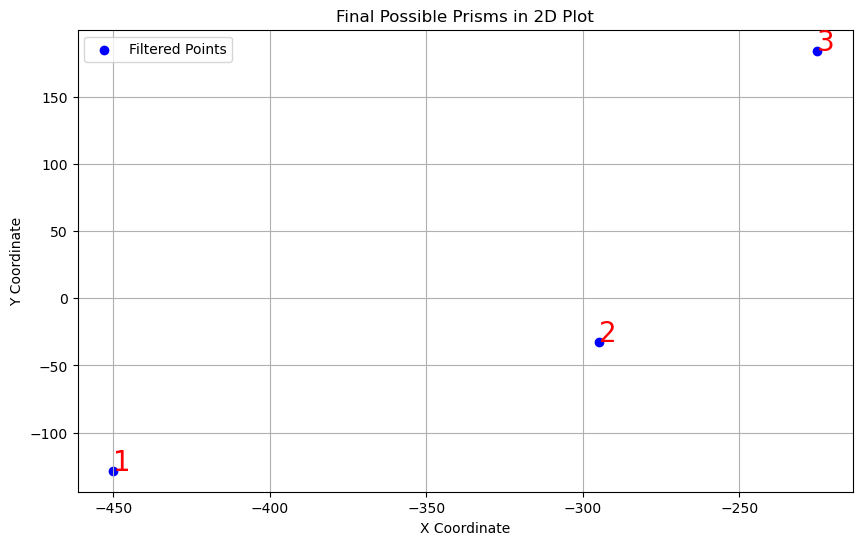

In [29]:
import matplotlib.pyplot as plt

# Extract X, Y, and Z coordinates
x_coords = filtered_list_prisms[:, 0]
y_coords = filtered_list_prisms[:, 1]

# Create a 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Filtered Points')

# Add labels to the points
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x, y, f"{i+1}", color='red', fontsize=20)

# Set plot labels
plt.title("Final Possible Prisms in 2D Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid()

# Show the plot
plt.show()




## Georeferencing Process with Rigid Transformation Method

In [31]:
import numpy as np

def compute_transformation_matrix(local_points, global_points):
    """
    Compute the transformation matrix to align local 3D coordinates to global 3D coordinates.

    :param local_points: Nx3 array of local 3D points
    :param global_points: Nx3 array of corresponding global 3D points
    :return: 4x4 transformation matrix
    """
    if local_points.shape != global_points.shape:
        raise ValueError("Local and global point sets must have the same shape.")

    # Step 1: Compute centroids
    local_centroid = np.mean(local_points, axis=0)
    global_centroid = np.mean(global_points, axis=0)

    # Step 2: Center the points
    centered_local = local_points - local_centroid
    centered_global = global_points - global_centroid

    # Step 3: Compute covariance matrix
    covariance_matrix = np.dot(centered_local.T, centered_global)

    # Step 4: Singular Value Decomposition (SVD)
    U, _, Vt = np.linalg.svd(covariance_matrix)
    R = np.dot(Vt.T, U.T)

    # Handle special reflection case
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Step 5: Compute translation
    t = global_centroid - np.dot(R, local_centroid)

    # Step 6: Construct the transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = t

    return transformation_matrix

# Example Usage
if __name__ == "__main__":
    # Example points in local and global coordinates
    local_points = filtered_list_prisms
    global_points = filtered_list_cp

    # Compute transformation matrix
    transformation_matrix = compute_transformation_matrix(local_points, global_points)
    print("Transformation Matrix:")
    print(transformation_matrix)

    # Apply the transformation to local points
    local_points_h = np.hstack((local_points, np.ones((local_points.shape[0], 1))))  # Convert to homogeneous coordinates
    transformed_points = np.dot(transformation_matrix, local_points_h.T).T[:, :3]   # Apply transformation
    print("Transformed Points:")
    print(transformed_points)


Transformation Matrix:
[[ 9.56792146e-01 -2.76774420e-01  8.91331032e-02  5.05116838e+04]
 [ 2.90403903e-01  8.94140212e-01 -3.40850192e-01  1.00457523e+05]
 [ 1.46411224e-02  3.52007388e-01  9.35882704e-01  2.17730875e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformed Points:
[[ 50111.74309594 100230.08278506   2076.04289704]
 [ 50233.15284958 100364.25344986   2103.00917031]
 [ 50236.80205448 100589.55476507   2148.82792665]]


## The differences between transformed points and the actual prisms in 3D

In [32]:
# Calculate differences (dx, dy, dz)
differences = transformed_points - global_points

# Display the differences
dx_dy_dz = differences

dx_dy_dz

array([[ 0.74809594, -0.07421494, -0.01710096],
       [-1.22915042,  0.34844986,  0.07417231],
       [ 0.48105448, -0.27423493, -0.05707135]])

## Applying the Transformation Matrix Result from the previous process to transform the whole Point Cloud

In [33]:
# Step 1: Read LAS file using laspy
input_las_path = input_file
las = laspy.read(input_las_path)

# Extract point coordinates
points = np.vstack((las.x, las.y, las.z)).T

# Step 2: Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Step 3: Apply transformation
pcd.transform(transformation_matrix)

# Step 4: Write transformed point cloud back to LAS
transformed_points = np.asarray(pcd.points)

# Update the LAS file with transformed points
las.x = transformed_points[:, 0]
las.y = transformed_points[:, 1]
las.z = transformed_points[:, 2]

output_las_path = "transformed_source_points.las"
las.write(output_las_path)

print(f"Transformed source points saved to {output_las_path}")


Transformed source points saved to transformed_source_points.las
